Method:
# $\sigma$   -> $\Pi$    -> $\bowtie$
	La projection Π 
    La sélection 𝜎
    La jointure ⋈ 

In [1]:
import datetime as dt 
import requests as rq
import matplotlib.pyplot as plt
import json 
from pandas import json_normalize
import time
import pandas as pd 
from pandasql import sqldf
import numpy as np
import psutil
import os
import csv
import re

# Adapters

Ce code Python est divisé en quatre classes, chacune étant un adaptateur pour une API différente.  Voici une explication de chacune de ces classes :

	EnergyAdapter1 : cet adaptateur est utilisé pour la première API sur l'énergie. Il possède une URL de base qui est utilisée pour accéder aux données de l'API. Il contient également une liste de noms de colonnes qui seront utilisés pour extraire les données des champs appropriés de la réponse JSON.  La méthode "get_energy_production" récupère les données de l'API et les formate en un DataFrame pandas.

	EnergyAdapter2 : cet adaptateur est utilisé pour la deuxième API sur l'énergie. Il utilise la même liste de colonnes que l'EnergyAdapter1, mais avec une URL différente. La méthode "get_energy_production" appelle la méthode correspondante dans EnergyAdapter1 et retourne le DataFrame résultant.

	PopulationAdapter : cet adaptateur est utilisé pour l'API sur la population. Il contient une URL de base et une liste de noms de colonnes pour extraire les données pertinentes de la réponse JSON. La méthode "get_population" appelle la méthode "get_energy_production" dans EnergyAdapter1 et renomme la colonne "reg_name" en "region" et récupérer les données correspondantes.

	LogementAdapter : cet adaptateur est utilisé pour l'API sur les logements sociaux. La méthode "API_Logement_sociaux_bailleurs" récupère les données de l'API qui concerne le logments et les bailleurs les formate en un DataFrame pandas.

En résumé, chaque adaptateur est responsable de récupérer les données d'une API spécifique et de les formater en un DataFrame pandas. Les méthodes dans les adaptateurs sont conçues pour être modulaires et réutilisables afin de faciliter l'ajout de nouvelles API à l'application.

In [2]:
class EnergyAdapter1:
    def __init__(self):
        """ The adapater for the first API Energy"""
        self.base_url = 'https://odre.opendatasoft.com/api/records/1.0/search/?dataset=consommation-quotidienne-brute-regionale&q=&sort=-consommation_brute_gaz_grtgaz&facet=date_heure&facet=code_insee_region&facet=region'
        self.list_of_cols = [ 'region', 'code_insee_region','date_heure', 'date', 'heure', 'consommation_brute_electricite_rte', 'consommation_brute_totale', 'consommation_brute_gaz_totale']

    def get_energy_production(self):
        response = rq.get(self.base_url)
        Repense = response.content
        parse_json = json.loads(Repense)
        n=parse_json['records'].__len__()
        list_data=[x for x in parse_json['records']]
        list_dic,df={},{}
        for i in range(n):
            list_dic[i] = {key: list_data[i]["fields"][key] for key in self.list_of_cols}
        data=pd.DataFrame.from_dict(list_dic[0], orient='index').T
        for i in range(1,n):
            df[i]=pd.DataFrame.from_dict(list_dic[i], orient='index').T
            data=pd.concat([data,df[i]], axis=0)
        return data
    
class EnergyAdapter2:
    def __init__(self):
        """ The adapater for the second API of Energy """
        self.base_url = "https://opendata.agenceore.fr/api/records/1.0/search/?dataset=production-demi-horaire-agregee-par-region&q=&sort=-horodate&facet=horodate&facet=region&facet=grd"
        self.list_of_cols = ['region','code','horodate','energie_injectee','nb_points_injection' ]
    def get_energy_production(self):
        return EnergyAdapter1.get_energy_production(self)

# population adapter
class PopulationAdapter:
    def __init__(self):
        """ The adapater for  Population API """
        self.base_url = "https://public.opendatasoft.com/api/records/1.0/search/?dataset=demographyref-france-pop-legale-commune-arrondissement-municipal-millesime&q=&rows=3536&facet=reg_code&facet=reg_name&facet=com_arm_code&facet=com_arm_name&facet=dep_code&facet=arrdep_code&facet=census_year&facet=start_year&facet=geo_year&facet=epci_name&facet=epci_code&facet=dep_name"
        self.list_of_cols = ['com_arm_pop_tot', 'reg_name', 'start_year', 'arrdep_code','geo_year', 'census_year',  'com_arm_code', 'com_arm_pop_mun', 'dep_code', 'com_arm_pop_cap', 'reg_code',  'com_arm_name'] 
        #'epci_name', 'epci_code', 'dep_name'

    def get_population(self):
        data=EnergyAdapter1.get_energy_production(self)
        data=data.rename(columns={"reg_name": "region"})
        return data

# Logement_sociaux_bailleurs adapter
class LogementAdapter:
    def __init__(self):
        """ The adapater for  Logement API """
        self.base_url = "https://opendata.caissedesdepots.fr/api/records/1.0/search/?dataset=bailleurs_sociaux_region&q=&rows=1000&facet=code_region&facet=libelle_region&facet=annee"
        self.list_of_cols = ['part_logement_sociaux_geres_sem', 'nbre_logements', 'code_region',
                             'nbre_bailleurs_consolide', 'part_logements_sociaux_geres_autres_bailleurs', 
                             'nbre_bailleurs','annee', 'libelle_region', 'part_logement_sociaux_geres_esh',
                             'part_logement_sociaux_geres_oph']
                              

    def API_Logement_sociaux_bailleurs(self):
        req = rq.get(self.base_url)
        data = json.loads(req.content)
        data = pd.DataFrame(data['records'])
        data.drop(columns=["datasetid", "recordid", "record_timestamp"], axis=1, inplace=True)
        data = json_normalize(data['fields'])
        data=data.rename(columns={"libelle_region": "region"})
        return pd.DataFrame(data)


# Mediator
Ce code crée une classe InformationMediator qui sert de médiateur entre quatre sources de données d'API différentes (API1, API2, API3 et API4), en sélectionnant les données selon des conditions de requête spécifiques et en retournant les données sélectionnées.

Les méthodes de la classe InformationMediator :

    init() : initialise quatre objets de classe adapter (EnergyAdapter1(), EnergyAdapter2(), PopulationAdapter() et LogementAdapter()), qui servent à récupérer les données de chaque API.

    get_API1_data() : renvoie les données de API1. 
    get_API2_data() : renvoie les données de API2. 
    get_API3_data() : renvoie les données de API3. 
    get_API4_data() : renvoie les données de API4.

* La fonction "restriction" prend en entrée 5 arguments : "Query" qui représente une requête SQL, et les 4 dataframes "df1", "df2", "df3" et "df4". L'objectif de cette fonction est de filtrer les données de chaque dataframe en utilisant les conditions spécifiées dans la requête SQL. La première étape consiste à extraire les conditions de la requête SQL en utilisant les expressions "WHERE" et "". Ensuite, la fonction utilise des expressions régulières pour identifier les opérateurs de comparaison dans chaque condition, tels que "<", ">", "=", "!=", "<=", ">=", etc. Ensuite, la fonction parcourt chaque condition et extrait le nom de colonne et l'opérateur de comparaison. En fonction du nom de la colonne, chaque condition est attribuée à un dataframe particulier, en suivant une série de règles conditionnelles. Si la colonne est présente dans plusieurs dataframes, la condition est attribuée à chaque dataframe concerné. Une fois que chaque condition a été attribuée à un dataframe, la fonction construit une requête SQL pour chaque dataframe en utilisant les conditions correspondantes. Enfin, elle exécute ces requêtes SQL et renvoie les dataframes filtrés.

* La  méthode nommée "projection"  commence par extraire les noms de colonnes de la requête SQL à l'aide des chaînes de caractères "SELECT" et "FROM". Elle stocke ensuite ces noms de colonnes dans une liste appelée "cols_in_query". Ensuite, la méthode parcourt chaque mot dans la liste "cols_in_query" et l'ajoute à l'une des quatre listes fournies en entrée en fonction de son appartenance à l'une ou plusieurs de ces listes. Si le mot se trouve dans les quatre listes, 
il est ajouté aux quatre listes (list_api1, list_api2, list_api3 et list_api4). S'il se trouve dans trois listes, il est ajouté à ces trois listes, et ainsi de suite. Finalement, la méthode retourne les quatre listes mises à jour.

* La méthode de jointure  prend en entrée quatre DataFrames ("df1", "df2", "df3" et "df4"), ainsi que quatre listes de noms des colonnes de chaque API correspondant à chaque DataFrame ("list_api1", "list_api2", "list_api3" et "list_api4"). La méthode effectue des jointures entre les DataFrames en fonction des listes d'API fournies. La méthode commence par vérifier quelle combinaison de listes d'API est fournie et effectue la jointure appropriée en conséquence. La méthode renvoie le DataFrame résultant de la jointure.

In [3]:
class InformationMediator:
    def __init__(self):
        self.energy_adapter1 =  EnergyAdapter1()
        self.energy_adapter2 =  EnergyAdapter2()
        self.population_adapter = PopulationAdapter()
        self.Logement_adapter = LogementAdapter()
    
    def get_API1_data(self):
        return pd.DataFrame(self.energy_adapter1.get_energy_production())    
    def get_API2_data(self):
        return pd.DataFrame(self.energy_adapter2.get_energy_production())        
    def get_API3_data(self):
        return pd.DataFrame(self.population_adapter.get_population())
    def get_API4_data(self):
        return pd.DataFrame(self.Logement_adapter.API_Logement_sociaux_bailleurs())
    
    def restriction(self,Query,df1,df2,df3,df4):
        
        start, end = "WHERE",""
        conds=Query[Query.find(start)+len(start):Query.rfind(end)].strip().split(' and ')
        pattern = r'[<>=!]=?'
        matches=[]
        conditions=[]
        cond_api1, cond_api2, cond_api3,cond_api4 = [], [], [], []
        df1Cols=df1.columns
        df2Cols=df2.columns
        df3Cols=df3.columns
        df4Cols=df4.columns
        
        for i in range(len(conds)):
            matches.append(re.findall(pattern, conds[i])[0])

        for i in range(len(conds)):
            pattern=conds[i].split(f'{matches[i]}')[0]
            if ( pattern in df1Cols) and (pattern in df2Cols) and (pattern in df3Cols) and (pattern in df4Cols):
                cond_api1.append(conds[i]), cond_api2.append(conds[i]), 
                cond_api3.append(conds[i]), cond_api4.append(conds[i])
            
            elif (pattern in df1Cols) and (pattern in df2Cols)and (pattern in df3Cols):
                cond_api1.append(conds[i]), cond_api2.append(conds[i]),cond_api3.append(conds[i])
            elif (pattern in df1Cols) and (pattern in df2Cols)and (pattern in df4Cols):
                cond_api1.append(conds[i]), cond_api2.append(conds[i]),cond_api4.append(conds[i])
            elif (pattern in df1Cols) and (pattern in df3Cols)and (pattern in df4Cols):
                cond_api1.append(conds[i]), cond_api3.append(conds[i]),cond_api4.append(conds[i])
            elif (pattern in df2Cols) and (pattern in df3Cols)and (pattern in df4Cols):
                cond_api2.append(conds[i]), cond_api3.append(conds[i]),cond_api4.append(conds[i])
            
            elif (pattern in df1Cols) and (pattern in df2Cols):
                cond_api1.append(conds[i]), cond_api2.append(conds[i])
            elif (pattern in df1Cols) and (pattern in df3Cols):
                cond_api1.append(conds[i]), cond_api3.append(conds[i])
            elif (pattern in df1Cols) and (pattern in df4Cols):
                cond_api1.append(conds[i]), cond_api4.append(conds[i])
            elif (pattern in df2Cols) and (pattern in df3Cols):
                cond_api2.append(conds[i]), cond_api3.append(conds[i])
            elif (pattern in df2Cols) and (pattern in df4Cols):
                cond_api2.append(conds[i]), cond_api4.append(conds[i])
            elif (pattern in df3Cols) and (pattern in df4Cols):
                cond_api3.append(conds[i]), cond_api4.append(conds[i])
            
            elif (pattern in df1Cols):
                cond_api1.append(conds[i])
            elif (pattern in df2Cols):
                cond_api2.append(conds[i])
            elif (pattern in df3Cols):
                cond_api3.append(conds[i])
            else:
                cond_api4.append(conds[i])
                
            cond1=' and '.join(i for i in cond_api1)
            cond2=' and '.join(i for i in cond_api2)
            cond3=' and '.join(i for i in cond_api3)
            cond4=' and '.join(i for i in cond_api4)
        #print("cond1: ", cond1, "cond2: ", cond2, "cond3: ", cond3)        
        
        Q1=f""" SELECT * FROM df1 WHERE {cond1} """
        Q2=f""" SELECT * FROM df2 WHERE {cond2} """
        Q3=f""" SELECT * FROM df3 WHERE {cond3} """
        Q4=f""" SELECT * FROM df4 WHERE {cond4} """
        
        if len(cond1)>1:
            df1=sqldf(Q1)
        if len(cond2)>1:
            df2=sqldf(Q2)
        if len(cond3)>1:
            df3=sqldf(Q3)
        if len(cond4)>1:
            df4=sqldf(Q4)
        
        #print("\n Shape apres la sélection")
        if len(cond1)>1:
            print(f"\n {df1.shape} = 𝜎_{cond1}_(API_1)")
        if len(cond2)>1:
            print(f"\n {df2.shape} = 𝜎_{cond2}_(API_2)")
        if len(cond3)>1:
            print(f"\n {df3.shape} = 𝜎_{cond3}_(API_3)")
        if len(cond4)>1:
            print(f"\n {df4.shape} = 𝜎_{cond4}_(API_4)")
            
        return df1,df2,df3,df4
    
    
    def projection(self,list_api_1, list_api_2, list_api_3, list_api_4,Query):
        start, end = 'SELECT', 'FROM'
        cols_in_query=Query[Query.find(start)+len(start):Query.rfind(end)].strip().split(', ')
        list_api1, list_api2, list_api3, list_api4 = [], [], [], []
        for word in cols_in_query:
            if (word in list_api_1) and (word in list_api_2) and (word in list_api_3) and (word in list_api_4):
                list_api1.append(word), list_api2.append(word)
                list_api3.append(word), list_api4.append(word)
            
            elif (word in list_api_1) and (word in list_api_2) and (word in list_api_3):
                list_api1.append(word), list_api2.append(word), list_api3.append(word)
            elif (word in list_api_1) and (word in list_api_2) and (word in list_api_4):
                list_api1.append(word), list_api2.append(word), list_api4.append(word)
            elif (word in list_api_1) and (word in list_api_3) and (word in list_api_4):
                list_api1.append(word), list_api3.append(word), list_api4.append(word)    
            elif (word in list_api_2) and (word in list_api_3) and (word in list_api_4):
                list_api2.append(word), list_api3.append(word), list_api4.append(word)

            elif (word in list_api_1) and (word in list_api_2):
                list_api1.append(word), list_api2.append(word)
            elif (word in list_api_1) and (word in list_api_3):
                list_api1.append(word), list_api3.append(word)
            elif (word in list_api_1) and (word in list_api_4):
                list_api1.append(word), list_api4.append(word)
                
            elif (word in list_api_2) and (word in list_api_3):
                list_api2.append(word), list_api3.append(word)
            elif (word in list_api_2) and (word in list_api_4):
                list_api2.append(word), list_api4.append(word)
                
            elif (word in list_api_3) and (word in list_api_4):
                list_api3.append(word), list_api4.append(word)

            elif (word in list_api_1):
                list_api1.append(word)
            elif (word in list_api_2) :
                list_api2.append(word)
            elif (word in list_api_3) :
                list_api3.append(word)
            else:
                list_api4.append(word) 

        
        return list_api1, list_api2, list_api3, list_api4
    
    def jointure(self,df1,df2,df3,df4,list_api1,list_api2,list_api3,list_api4):
        
        if len(list_api1)>1 and len(list_api2)>1 and len(list_api3)>1 and len(list_api4)>1:
            df123=pd.merge(pd.merge(df1, df2, on = 'region'), df4, on = 'region')
            df=pd.DataFrame(pd.merge(df123, df3, on = 'region'))
            print(f"\n {df.shape} = (API_1 ⋈ API_2 ⋈ API_3 ⋈ API_4)")
            
        elif len(list_api1)>1 and len(list_api2)>1 and len(list_api3)>1:
            df=pd.merge(pd.merge(df1, df2,  on = 'region'),df3,on = 'region')
            print(f"\n {df.shape} = (API_1 ⋈ API_2 ⋈ API_3 )")
        elif len(list_api1)>1 and len(list_api2)>1 and len(list_api4)>1:
            df=pd.merge(pd.merge(df1, df2,  on = 'region'),df4,on = 'region')
            print(f"\n {df.shape} = (API_1 ⋈ API_2 ⋈ API_4)")
        elif len(list_api1)>1 and len(list_api3)>1 and len(list_api4)>1:
            df=pd.merge(pd.merge(df1, df4,  on = 'region'),df3,on = 'region')
            print(f"\n {df.shape} = (API_1 ⋈ API_3 ⋈ API_4)")
        elif len(list_api2)>1 and len(list_api3)>1 and len(list_api4)>1:
            df=pd.merge(pd.merge(df2, df4,  on = 'region'),df3,on = 'region')
            print(f"\n {df.shape} = (API_2 ⋈ API_3 ⋈ API_4)")
        
        elif len(list_api1)>1 and len(list_api2)>1 :
            df=pd.DataFrame(pd.merge(df1, df2,  on = 'region'))
            print(f"\n {df.shape} = (API_1 ⋈ API_2)")
        elif len(list_api1)>1 and len(list_api3)>1 :
            df=pd.DataFrame(pd.merge(df1, df3,  on = 'region'))
            print(f"\n {df.shape} = (API_1 ⋈ API_3)")
        elif len(list_api1)>1 and len(list_api4)>1 :
            df=pd.DataFrame(pd.merge(df1, df4,  on = 'region'))
            print(f"\n {df.shape} = (API_1 ⋈ API_4)")
            
        elif len(list_api2)>1 and len(list_api3)>1 :
            df=pd.DataFrame(pd.merge(df2, df3,  on = 'region'))
            print(f"\n {df.shape} = (API_2 ⋈ API_3)")
        elif len(list_api2)>1 and len(list_api4)>1 :
            df=pd.DataFrame(pd.merge(df2, df4,  on = 'region'))
            print(f"\n {df.shape} = (API_2 ⋈ API_4)")
            
        elif len(list_api3)>1 and len(list_api4)>1 :
            df=pd.DataFrame(pd.merge(df3, df4,  on = 'region'))
            print(f"\n{df.shape} = (API_3 ⋈ API_4)")
            
        elif len(list_api1)>1 :
            df=pd.DataFrame(df1)
            print(f"\n {df.shape} = (API_1)")
            
        elif len(list_api2)>1 :
            df=pd.DataFrame(df2)
            print(f"\n {df.shape} = (API_2)")
        
        elif len(list_api3)>1 :
            df=pd.DataFrame(df3)
            print(f"\n {df.shape} = (API_3)")
        
        else:
            df=pd.DataFrame(df4)
            print(f"\n {df.shape} = (API_4)")
        #print( '\n\n cols of df:' , df.columns)
        return df  
    
    
    
    def data(self,Query):      
        
        print('\n ---------------- APIs shapes: ----------------')
        informationMediator = InformationMediator()
        df1 = informationMediator.get_API1_data()  
        df2 = informationMediator.get_API2_data()  
        df3 = informationMediator.get_API3_data()
        df4 = informationMediator.get_API4_data()
        print(f" API_1 :{df1.shape}")
        print(f" API_2 :{df2.shape}")
        print(f" API_3 :{df3.shape}")
        print(f" API_4 :{df4.shape}")
        print('\n ----------------------------------------------')
        
        # La sélection 𝜎
        print('\n -------- 𝜎 ')
        if 'WHERE' in Query:
            #print("\n Selection d'abord par conditions")
            df1,df2,df3,df4 = self.restriction(Query,df1,df2,df3,df4)
        else:
            print("\n pas de 𝜎")
        #print('\n -------------------------------------------') 
        
        # Π : La projection
        print('\n -------- Π ')
        list_api_1, list_api_2, list_api_3, list_api_4 = df1.columns, df2.columns, df3.columns, df4.columns
        list_api1,list_api2,list_api3,list_api4 = self.projection(list_api_1, list_api_2, list_api_3, list_api_4, Query)
        df1, df2, df3, df4 = df1[list_api1], df2[list_api2], df3[list_api3], df4[list_api4]
        #print('\n Shapes apres projection:')
        
        if len(list_api1)>1 :
            print(f"\n {df1.shape} = Π_{list_api1}_(API_1)")
        if len(list_api2)>1 :
            print(f"\n {df2.shape} = Π_{list_api2}_(API_2)")
        if len(list_api3)>1 :
            print(f"\n {df3.shape} = Π_{list_api3}_(API_3)")
        if len(list_api4)>1 :
            print(f"\n {df4.shape} = Π_{list_api4}_(API_4)")
        #print('\n -------------------------------------------') 


        # ⋈ : La jointure 
        print('\n -------- ⋈')
        df = self.jointure(df1,df2,df3,df4,
                           list_api1,
                           list_api2,
                           list_api3,
                           list_api4)             
        print('\n -------------------------------------------')
                
        
        return df

# Test

## Récupérer la consommation brute d'électricité par région et par heure d'injection d'énergie :

In [4]:
FirstQuery="""
SELECT region, heure, consommation_brute_electricite_rte, energie_injectee 
FROM df"""

pid = os.getpid()
py = psutil.Process(pid)
cpuStart = py.cpu_percent()
memoryStart = py.memory_info()[0] / 2. ** 30
start_time = time.time()

InformationMediator().data(FirstQuery)

elapsed_time =abs(time.time() - start_time)
cpuEnd = py.cpu_percent()
memoryEnd = py.memory_info()[0] / 2. ** 30
cpu=abs(cpuEnd - cpuStart)
memory=abs(memoryEnd - memoryStart)
print("Temps d'exécution : ", elapsed_time, " secondes.")
print("CPU utilization:", cpu)
print("Memory utilization:", memory)

data=(elapsed_time,cpu,memory)
with open('4APIs_data_saved.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(data)


 ---------------- APIs shapes: ----------------
 API_1 :(10, 8)
 API_2 :(10, 5)
 API_3 :(3536, 12)
 API_4 :(14, 10)

 ----------------------------------------------

 -------- 𝜎 

 pas de 𝜎

 -------- Π 

 (10, 3) = Π_['region', 'heure', 'consommation_brute_electricite_rte']_(API_1)

 (10, 2) = Π_['region', 'energie_injectee']_(API_2)

 -------- ⋈

 (7, 4) = (API_1 ⋈ API_2)

 -------------------------------------------
Temps d'exécution :  17.92650532722473  secondes.
CPU utilization: 19.7
Memory utilization: 0.0112762451171875


## Récupérer la consommation brute d'électricité par région et par année de recensement,avec des informations sur les logements sociaux :


In [5]:
FirstQuery="""SELECT region, annee, consommation_brute_electricite_rte, part_logement_sociaux_geres_sem 
FROM df """

pid = os.getpid()
py = psutil.Process(pid)
cpuStart = py.cpu_percent()
memoryStart = py.memory_info()[0] / 2. ** 30
start_time = time.time()

InformationMediator().data(FirstQuery)

elapsed_time =abs(time.time() - start_time)
cpuEnd = py.cpu_percent()
memoryEnd = py.memory_info()[0] / 2. ** 30
cpu=abs(cpuEnd - cpuStart)
memory=abs(memoryEnd - memoryStart)
print("Temps d'exécution : ", elapsed_time, " secondes.")
print("CPU utilization:", cpu)
print("Memory utilization:", memory)

data=(elapsed_time,cpu,memory)
with open('4APIs_data_saved.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(data)


 ---------------- APIs shapes: ----------------
 API_1 :(10, 8)
 API_2 :(10, 5)
 API_3 :(3536, 12)
 API_4 :(14, 10)

 ----------------------------------------------

 -------- 𝜎 

 pas de 𝜎

 -------- Π 

 (10, 2) = Π_['region', 'consommation_brute_electricite_rte']_(API_1)

 (14, 3) = Π_['region', 'annee', 'part_logement_sociaux_geres_sem']_(API_4)

 -------- ⋈

 (8, 4) = (API_1 ⋈ API_4)

 -------------------------------------------
Temps d'exécution :  10.233123779296875  secondes.
CPU utilization: 40.3
Memory utilization: 0.0067596435546875


## Récupérer le nombre de points d'injection d'énergie par région et par département, avec des informations sur les logements sociaux :

In [6]:
FirstQuery="""SELECT region, dep_code, nb_points_injection, part_logement_sociaux_geres_sem 
FROM df """

pid = os.getpid()
py = psutil.Process(pid)
cpuStart = py.cpu_percent()
memoryStart = py.memory_info()[0] / 2. ** 30
start_time = time.time()

InformationMediator().data(FirstQuery)

elapsed_time =abs(time.time() - start_time)
cpuEnd = py.cpu_percent()
memoryEnd = py.memory_info()[0] / 2. ** 30
cpu=abs(cpuEnd - cpuStart)
memory=abs(memoryEnd - memoryStart)
print("Temps d'exécution : ", elapsed_time, " secondes.")
print("CPU utilization:", cpu)
print("Memory utilization:", memory)

data=(elapsed_time,cpu,memory)
with open('4APIs_data_saved.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(data)


 ---------------- APIs shapes: ----------------
 API_1 :(10, 8)
 API_2 :(10, 5)
 API_3 :(3536, 12)
 API_4 :(14, 10)

 ----------------------------------------------

 -------- 𝜎 

 pas de 𝜎

 -------- Π 

 (10, 2) = Π_['region', 'nb_points_injection']_(API_2)

 (3536, 2) = Π_['region', 'dep_code']_(API_3)

 (14, 2) = Π_['region', 'part_logement_sociaux_geres_sem']_(API_4)

 -------- ⋈

 (1512, 4) = (API_2 ⋈ API_3 ⋈ API_4)

 -------------------------------------------
Temps d'exécution :  11.379915237426758  secondes.
CPU utilization: 50.4
Memory utilization: 0.003368377685546875


## Récupérer la consommation brute de gaz par région et par année de recensement :

In [7]:
FirstQuery="""
SELECT region, annee, consommation_brute_gaz_totale
FROM df """

pid = os.getpid()
py = psutil.Process(pid)
cpuStart = py.cpu_percent()
memoryStart = py.memory_info()[0] / 2. ** 30
start_time = time.time()

InformationMediator().data(FirstQuery)

elapsed_time =abs(time.time() - start_time)
cpuEnd = py.cpu_percent()
memoryEnd = py.memory_info()[0] / 2. ** 30
cpu=abs(cpuEnd - cpuStart)
memory=abs(memoryEnd - memoryStart)
print("Temps d'exécution : ", elapsed_time, " secondes.")
print("CPU utilization:", cpu)
print("Memory utilization:", memory)

data=(elapsed_time,cpu,memory)
with open('4APIs_data_saved.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(data)


 ---------------- APIs shapes: ----------------
 API_1 :(10, 8)
 API_2 :(10, 5)
 API_3 :(3536, 12)
 API_4 :(14, 10)

 ----------------------------------------------

 -------- 𝜎 

 pas de 𝜎

 -------- Π 

 (10, 2) = Π_['region', 'consommation_brute_gaz_totale']_(API_1)

 (14, 2) = Π_['region', 'annee']_(API_4)

 -------- ⋈

 (8, 3) = (API_1 ⋈ API_4)

 -------------------------------------------
Temps d'exécution :  8.765501022338867  secondes.
CPU utilization: 52.6
Memory utilization: 0.002567291259765625


## Récupérer le nombre de bailleurs par région et par année de recensement, avec des informations sur les logements sociaux :

In [8]:
FirstQuery="""
SELECT region, annee, nbre_bailleurs, part_logement_sociaux_geres_sem
FROM df """

pid = os.getpid()
py = psutil.Process(pid)
cpuStart = py.cpu_percent()
memoryStart = py.memory_info()[0] / 2. ** 30
start_time = time.time()

InformationMediator().data(FirstQuery)

elapsed_time =abs(time.time() - start_time)
cpuEnd = py.cpu_percent()
memoryEnd = py.memory_info()[0] / 2. ** 30
cpu=abs(cpuEnd - cpuStart)
memory=abs(memoryEnd - memoryStart)
print("Temps d'exécution : ", elapsed_time, " secondes.")
print("CPU utilization:", cpu)
print("Memory utilization:", memory)

data=(elapsed_time,cpu,memory)
with open('4APIs_data_saved.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(data)


 ---------------- APIs shapes: ----------------
 API_1 :(10, 8)
 API_2 :(10, 5)
 API_3 :(3536, 12)
 API_4 :(14, 10)

 ----------------------------------------------

 -------- 𝜎 

 pas de 𝜎

 -------- Π 

 (14, 4) = Π_['region', 'annee', 'nbre_bailleurs', 'part_logement_sociaux_geres_sem']_(API_4)

 -------- ⋈

 (14, 4) = (API_4)

 -------------------------------------------
Temps d'exécution :  14.465975284576416  secondes.
CPU utilization: 37.5
Memory utilization: 0.000347137451171875


## Récupérer la consommation brute totale par région et par département, avec des informations sur la population :

In [9]:
FirstQuery="""
SELECT region, consommation_brute_totale, com_arm_pop_tot
FROM df """

pid = os.getpid()
py = psutil.Process(pid)
cpuStart = py.cpu_percent()
memoryStart = py.memory_info()[0] / 2. ** 30
start_time = time.time()

InformationMediator().data(FirstQuery)

elapsed_time =abs(time.time() - start_time)
cpuEnd = py.cpu_percent()
memoryEnd = py.memory_info()[0] / 2. ** 30
cpu=abs(cpuEnd - cpuStart)
memory=abs(memoryEnd - memoryStart)
print("Temps d'exécution : ", elapsed_time, " secondes.")
print("CPU utilization:", cpu)
print("Memory utilization:", memory)

data=(elapsed_time,cpu,memory)
with open('4APIs_data_saved.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(data)


 ---------------- APIs shapes: ----------------
 API_1 :(10, 8)
 API_2 :(10, 5)
 API_3 :(3536, 12)
 API_4 :(14, 10)

 ----------------------------------------------

 -------- 𝜎 

 pas de 𝜎

 -------- Π 

 (10, 2) = Π_['region', 'consommation_brute_totale']_(API_1)

 (3536, 2) = Π_['region', 'com_arm_pop_tot']_(API_3)

 -------- ⋈

 (2499, 3) = (API_1 ⋈ API_3)

 -------------------------------------------
Temps d'exécution :  11.085561990737915  secondes.
CPU utilization: 43.9
Memory utilization: 2.288818359375e-05


## Récupérer la consommation brute de gaz totale par région et par année de recensement, avec des informations sur les logements sociaux, la population et le nombre de bailleurs :

In [10]:
FirstQuery="""
SELECT region, consommation_brute_gaz_totale, com_arm_pop_tot, nbre_bailleurs, part_logement_sociaux_geres_oph
FROM df """

pid = os.getpid()
py = psutil.Process(pid)
cpuStart = py.cpu_percent()
memoryStart = py.memory_info()[0] / 2. ** 30
start_time = time.time()

InformationMediator().data(FirstQuery)

elapsed_time =abs(time.time() - start_time)
cpuEnd = py.cpu_percent()
memoryEnd = py.memory_info()[0] / 2. ** 30
cpu=abs(cpuEnd - cpuStart)
memory=abs(memoryEnd - memoryStart)
print("Temps d'exécution : ", elapsed_time, " secondes.")
print("CPU utilization:", cpu)
print("Memory utilization:", memory)

data=(elapsed_time,cpu,memory)
with open('4APIs_data_saved.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(data)


 ---------------- APIs shapes: ----------------
 API_1 :(10, 8)
 API_2 :(10, 5)
 API_3 :(3536, 12)
 API_4 :(14, 10)

 ----------------------------------------------

 -------- 𝜎 

 pas de 𝜎

 -------- Π 

 (10, 2) = Π_['region', 'consommation_brute_gaz_totale']_(API_1)

 (3536, 2) = Π_['region', 'com_arm_pop_tot']_(API_3)

 (14, 3) = Π_['region', 'nbre_bailleurs', 'part_logement_sociaux_geres_oph']_(API_4)

 -------- ⋈

 (1801, 5) = (API_1 ⋈ API_3 ⋈ API_4)

 -------------------------------------------
Temps d'exécution :  15.954360723495483  secondes.
CPU utilization: 36.7
Memory utilization: 0.000629425048828125


## Récupérer la consommation brute totale par région et par année, avec des informations sur le nombre de logements et la proportion de logements sociaux gérés par les SEM :

result = result.groupby(['region', 'date'])

In [11]:
FirstQuery="""
SELECT region, date, consommation_brute_totale, nbre_logements, part_logement_sociaux_geres_sem
FROM df """

pid = os.getpid()
py = psutil.Process(pid)
cpuStart = py.cpu_percent()
memoryStart = py.memory_info()[0] / 2. ** 30
start_time = time.time()

InformationMediator().data(FirstQuery)

elapsed_time =abs(time.time() - start_time)
cpuEnd = py.cpu_percent()
memoryEnd = py.memory_info()[0] / 2. ** 30
cpu=abs(cpuEnd - cpuStart)
memory=abs(memoryEnd - memoryStart)
print("Temps d'exécution : ", elapsed_time, " secondes.")
print("CPU utilization:", cpu)
print("Memory utilization:", memory)

data=(elapsed_time,cpu,memory)
with open('4APIs_data_saved.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(data)


 ---------------- APIs shapes: ----------------
 API_1 :(10, 8)
 API_2 :(10, 5)
 API_3 :(3536, 12)
 API_4 :(14, 10)

 ----------------------------------------------

 -------- 𝜎 

 pas de 𝜎

 -------- Π 

 (10, 3) = Π_['region', 'date', 'consommation_brute_totale']_(API_1)

 (14, 3) = Π_['region', 'nbre_logements', 'part_logement_sociaux_geres_sem']_(API_4)

 -------- ⋈

 (8, 5) = (API_1 ⋈ API_4)

 -------------------------------------------
Temps d'exécution :  11.918206930160522  secondes.
CPU utilization: 48.6
Memory utilization: 0.00173187255859375


## Récupérer le nombre de points d'injection d'énergie par région et par année de recensement, avec des informations sur la population et le nombre de logements sociaux gérés par les OPH

In [12]:
FirstQuery="""
SELECT region, annee, nb_points_injection, com_arm_pop_tot, part_logement_sociaux_geres_oph, nbre_logements
FROM df """

pid = os.getpid()
py = psutil.Process(pid)
cpuStart = py.cpu_percent()
memoryStart = py.memory_info()[0] / 2. ** 30
start_time = time.time()

InformationMediator().data(FirstQuery)

elapsed_time =abs(time.time() - start_time)
cpuEnd = py.cpu_percent()
memoryEnd = py.memory_info()[0] / 2. ** 30
cpu=abs(cpuEnd - cpuStart)
memory=abs(memoryEnd - memoryStart)
print("Temps d'exécution : ", elapsed_time, " secondes.")
print("CPU utilization:", cpu)
print("Memory utilization:", memory)

data=(elapsed_time,cpu,memory)
with open('4APIs_data_saved.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(data)


 ---------------- APIs shapes: ----------------
 API_1 :(10, 8)
 API_2 :(10, 5)
 API_3 :(3536, 12)
 API_4 :(14, 10)

 ----------------------------------------------

 -------- 𝜎 

 pas de 𝜎

 -------- Π 

 (10, 2) = Π_['region', 'nb_points_injection']_(API_2)

 (3536, 2) = Π_['region', 'com_arm_pop_tot']_(API_3)

 (14, 4) = Π_['region', 'annee', 'part_logement_sociaux_geres_oph', 'nbre_logements']_(API_4)

 -------- ⋈

 (1512, 6) = (API_2 ⋈ API_3 ⋈ API_4)

 -------------------------------------------
Temps d'exécution :  13.31418490409851  secondes.
CPU utilization: 31.9
Memory utilization: 0.00342559814453125


## Récupérer les informations sur la population totale la ou >10000 et la population municipale  par région d'Occitanie et par année de recensement  :

In [13]:
FirstQuery="""
SELECT region, date, com_arm_pop_tot, com_arm_pop_mun
FROM df 
WHERE region='Occitanie' and com_arm_pop_tot>10000"""

pid = os.getpid()
py = psutil.Process(pid)
cpuStart = py.cpu_percent()
memoryStart = py.memory_info()[0] / 2. ** 30
start_time = time.time()

InformationMediator().data(FirstQuery)

elapsed_time =abs(time.time() - start_time)
cpuEnd = py.cpu_percent()
memoryEnd = py.memory_info()[0] / 2. ** 30
cpu=abs(cpuEnd - cpuStart)
memory=abs(memoryEnd - memoryStart)
print("Temps d'exécution : ", elapsed_time, " secondes.")
print("CPU utilization:", cpu)
print("Memory utilization:", memory)

data=(elapsed_time,cpu,memory)
with open('4APIs_data_saved.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(data)


 ---------------- APIs shapes: ----------------
 API_1 :(10, 8)
 API_2 :(10, 5)
 API_3 :(3536, 12)
 API_4 :(14, 10)

 ----------------------------------------------

 -------- 𝜎 

 (1, 8) = 𝜎_region='Occitanie'_(API_1)

 (0, 5) = 𝜎_region='Occitanie'_(API_2)

 (8, 12) = 𝜎_region='Occitanie' and com_arm_pop_tot>10000_(API_3)

 (1, 10) = 𝜎_region='Occitanie'_(API_4)

 -------- Π 

 (1, 2) = Π_['region', 'date']_(API_1)

 (8, 3) = Π_['region', 'com_arm_pop_tot', 'com_arm_pop_mun']_(API_3)

 -------- ⋈

 (8, 4) = (API_1 ⋈ API_3)

 -------------------------------------------
Temps d'exécution :  17.188960790634155  secondes.
CPU utilization: 31.9
Memory utilization: 0.00252532958984375


## Affichage de la durée d'exécution, la mémoire et l'utilisation du processeur des requêtes testées ci-dessus :

In [31]:
Queries=['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10']
data=pd.read_csv('4APIs_data_saved.csv')
data.insert(0,'Queries', Queries)
data.head()

,Queries,Times,CPU,Memory
0,Q1,17.926505,19.7,0.011276
1,Q2,10.233124,40.3,0.006760
2,Q3,11.379915,50.4,0.003368
3,Q4,8.765501,52.6,0.002567
4,Q5,14.465975,37.5,0.000347


<AxesSubplot: xlabel='Queries'>

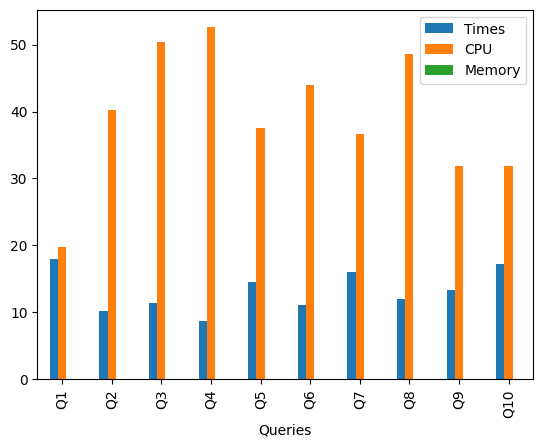

In [16]:
data.plot(kind='bar', x='Queries')

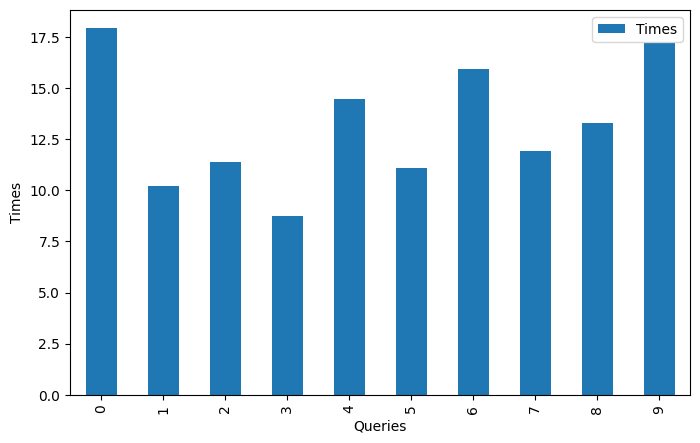

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=1 , figsize=(8,5))
data['Times'].plot(kind='bar',x='Queries', legend='Times')
axes.set_ylabel("Times")
axes.set_xlabel('Queries') 
fig.savefig("Times.jpg")

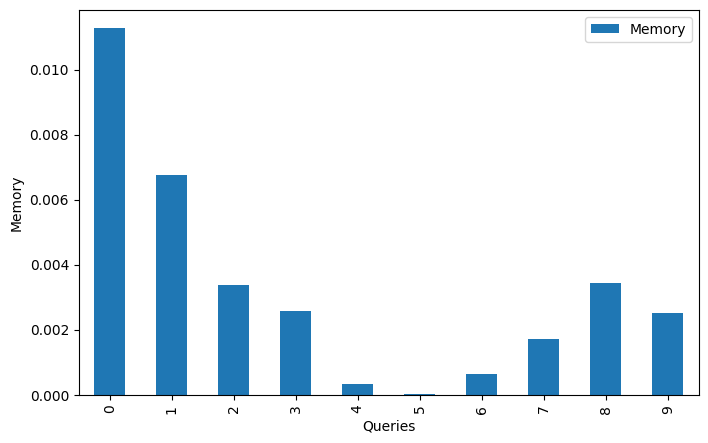

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=1 , figsize=(8,5))
data['Memory'].plot(kind='bar',x='Queries', legend='Memory')
axes.set_ylabel("Memory")
axes.set_xlabel('Queries')
fig.savefig("Memory.jpg")

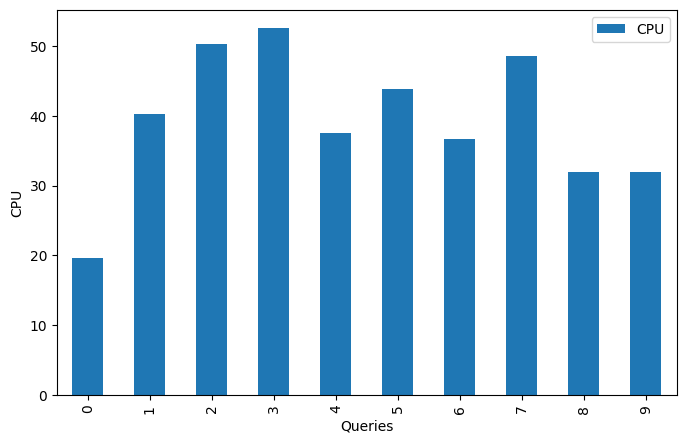

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=1 , figsize=(8,5))
data['CPU'].plot(kind='bar',x='Queries', legend='CPU usage')
axes.set_ylabel("CPU")
axes.set_xlabel('Queries')
fig.savefig("CPU.jpg")